# Histopathological Cancer Detection

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

The Histopathological Cancer Detection aims to use cutting edge deep learning techniques to identify matastatic cancer in small images. The data supplied by Kaggle is a modified version of the PatchCamelyon dataset which contains more than 220,000 32x32 pixel images (in the .tif format) with a label of 0 for an example of a cell picture that does not contain a pixel of tumerous tissue whereas the 1 label is an example of a call p icture that does contain at least one pixel of tumerous tissue. The data is split into a train and test folder that contains the respective test and training images. Also included is a train_labels.csv file that provies the labels for the train dataset that can be used to train our CNN. 

For my implementation I will use a Convolutional Neural Network (CNN) using Pytorch to create an end to end model. The model will ouput the test id as well as a 0 or 1 label indicating the models prediction.  

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split

from cancer_dataset import CancerDataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} :( ")

Using device: cpu


In [3]:
train_dir = '/Users/cman/Desktop/code/histopathological_cancer_detection/histopathological_cancer_detection/train/'
test_dir =  '/Users/cman/Desktop/code/histopathological_cancer_detection/histopathological_cancer_detection/test/'
labels = pd.read_csv('/Users/cman/Desktop/code/histopathological_cancer_detection/histopathological_cancer_detection/train_labels.csv')

In [4]:
# Append .tif extension to image IDs
labels['id'] = labels['id'] + '.tif'

In [5]:
labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835.tif      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif      1
2  755db6279dae599ebb4d39a9123cce439965282d.tif      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif      0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif      0

In [6]:
print(f'The number of datapoints: {len(labels)}')

The number of datapoints: 220025


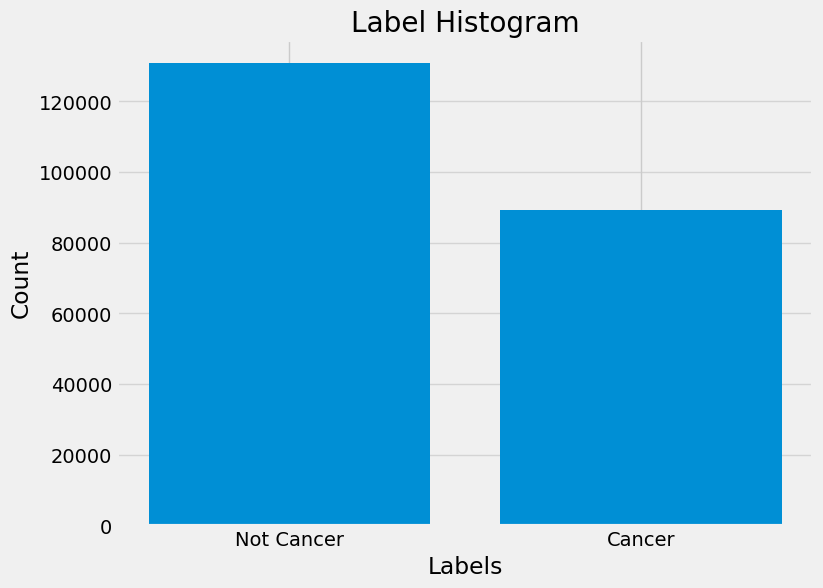

In [7]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (8, 6))
plt.hist(labels['label'], bins = [-0.5, .5, 1.5], rwidth=0.8)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Cancer', 'Cancer'])
plt.title('Label Histogram')
plt.grid(axis = 'y', alpha = 0.75)
plt.show()

## Visualize Images

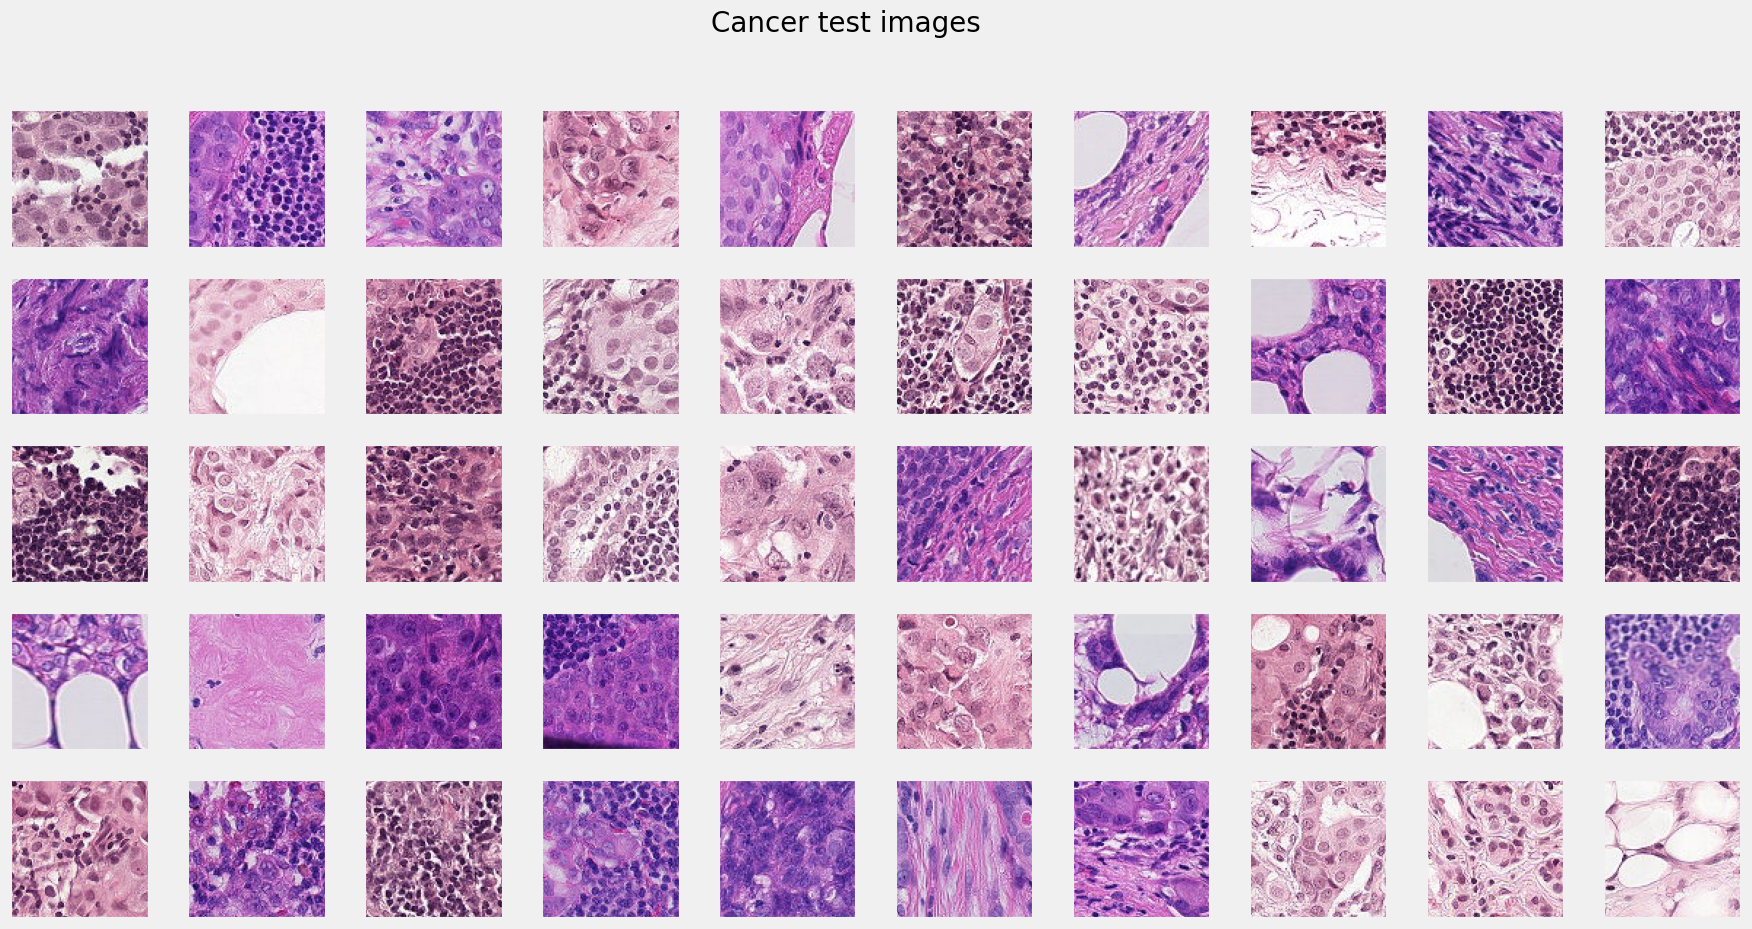

In [8]:
fig, ax = plt.subplots(5, 10, figsize = (20, 10))


for n in range(5):
    for m in range(10):
        img_id = np.random.choice(labels[labels.label==1].id, size=50, replace=False)[m + n * 10]
        image = plt.imread(train_dir + img_id)
        ax[n, m].imshow(image)
        ax[n, m].grid(False)
        ax[n, m].tick_params(labelbottom = False, labelleft = False)

fig.suptitle('Cancer test images', fontsize=20)
plt.show()

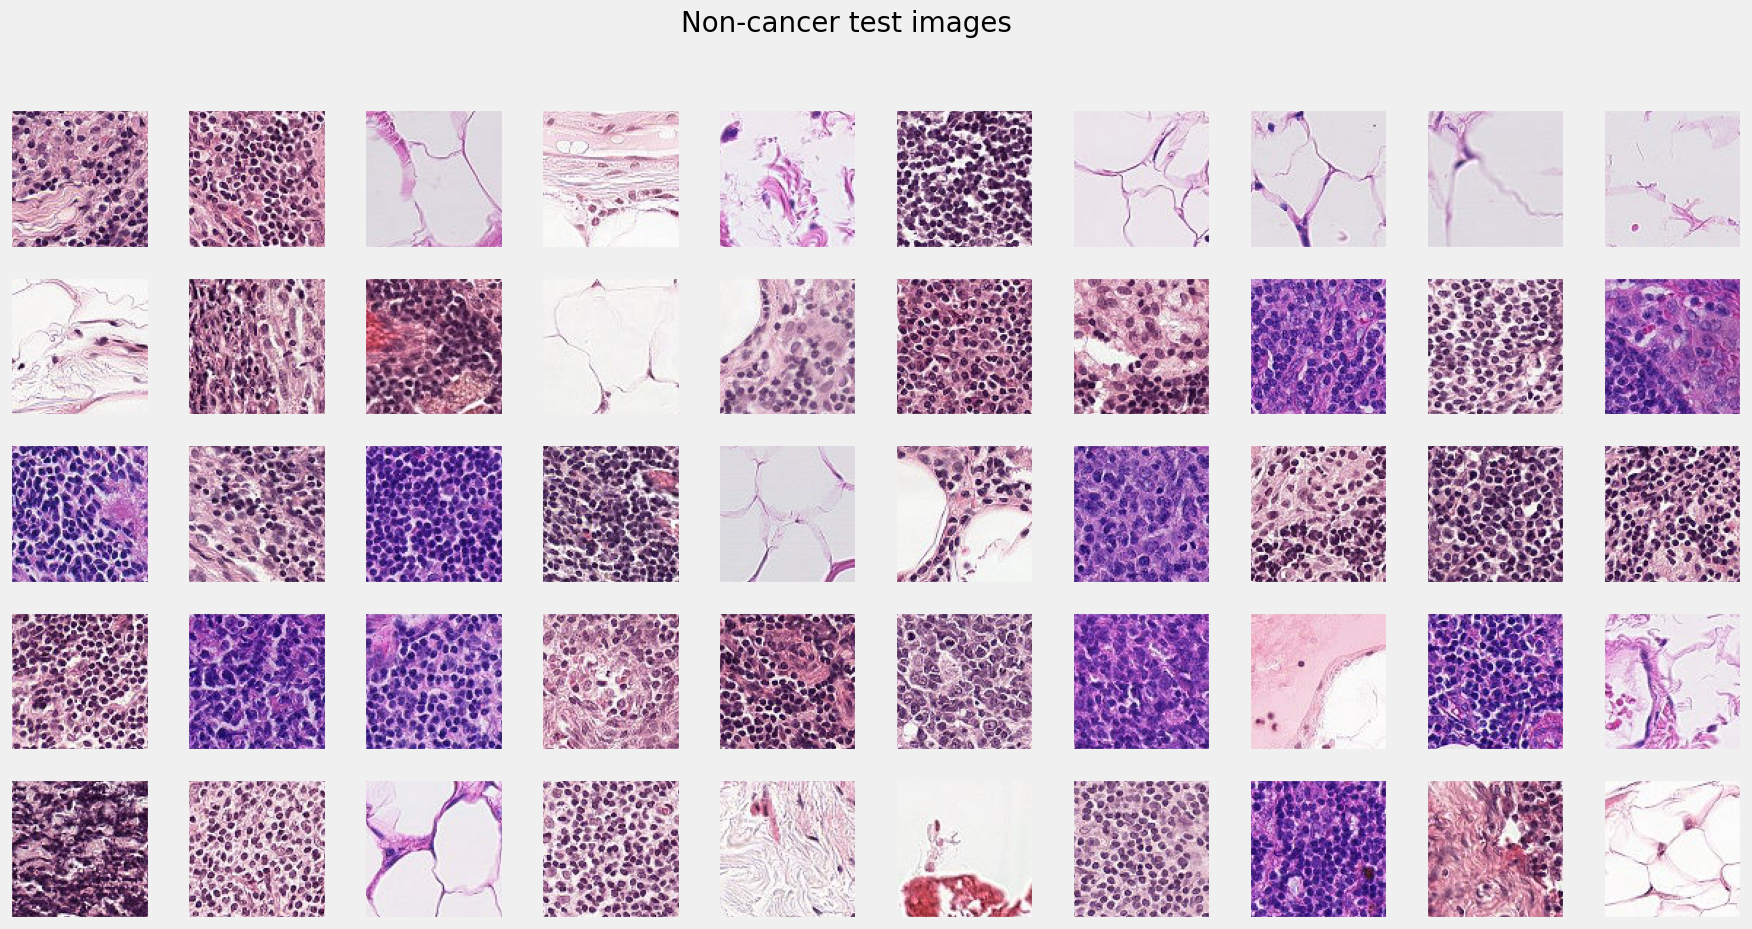

In [9]:
fig, ax = plt.subplots(5, 10, figsize = (20, 10))


for n in range(5):
    for m in range(10):
        img_id = np.random.choice(labels[labels.label==0].id, size=50, replace=False)[m + n * 10]
        image = plt.imread(train_dir + img_id)
        ax[n, m].imshow(image)
        ax[n, m].grid(False)
        ax[n, m].tick_params(labelbottom = False, labelleft = False)

fig.suptitle('Non-cancer test images', fontsize=20)
plt.show()

## Train Test Split

In [10]:
train_df, val_df = train_test_split(labels, stratify = labels['label'], test_size = 0.15, random_state = 42)

In [11]:
print(f'The number of values in the training set is: {len(train_df)} and the number of values in the validation set is: {len(val_df)}')

The number of values in the training set is: 187021 and the number of values in the validation set is: 33004


## Dataset Class

In [12]:
# class CancerDataset(Dataset):
#     def __init__(self, dataframe, img_dir, transform = None, mode = 'train'):
#         self.dataframe = dataframe
#         self.img_dir = img_dir
#         self.transform = transform
#         self.mode = mode

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
#         image = Image.open(img_name)

#         if self.transform:
#             image = self.transform(image)
        
#         if self.mode == 'train' or self.mode == 'val':
#             label = int(self.dataframe.iloc[idx, 1])
#             return image, label
#         else:
#             return image

## Data Augumentation and Normalization

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(96),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(96),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(100),
        transforms.CenterCrop(96),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Create DataLoader

In [14]:
train_dataset = CancerDataset(train_df, train_dir, transform = data_transforms['train'], mode = 'train')
val_dataset = CancerDataset(val_df, train_dir, transform = data_transforms['val'], mode = 'val')

In [15]:
train_dataset

In [16]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False, num_workers = 4)

## CNN Model

In [17]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(256)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 512),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Initialize Model, Loss Function, and Optimizer

## Train Function

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 15):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1} / {num_epochs}')
        print('-' * 20)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            running_corrects += torch.sum(preds == labels)

        scheduler.step()

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f'Training loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                preds = (outputs > 0.5).float()
                val_corrects += torch.sum(preds == labels)

        epoch_val_loss = val_loss / len(val_dataset)
        epoch_val_acc = val_corrects.double() / len(val_dataset)

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())

        print(f'Validation loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}\n')
    
    return history

In [19]:
if __name__ == '__main__':
    model = CNNModel().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
    num_epochs = 20
    history = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 1 / 15
--------------------
Training loss: 0.4838, Accuracy: 0.7753
Validation loss: 0.3964, Accuracy: 0.8183

Epoch 2 / 15
--------------------
Training loss: 0.4386, Accuracy: 0.8023
Validation loss: 0.3538, Accuracy: 0.8445

Epoch 3 / 15
--------------------
Training loss: 0.4097, Accuracy: 0.8176
Validation loss: 0.3082, Accuracy: 0.8675

Epoch 4 / 15
--------------------
Training loss: 0.3834, Accuracy: 0.8325
Validation loss: 0.2870, Accuracy: 0.8782

Epoch 5 / 15
--------------------
Training loss: 0.3646, Accuracy: 0.8435
Validation loss: 0.2740, Accuracy: 0.8898

Epoch 6 / 15
--------------------


## Model Training

## Data Cleaning

## EDA

## Model Architecture

escribe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

## Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

In conclusion, the task of detecting cancerous cells in histopathological images was no small task. It took very a very precise deep learning architecture to achieve the required outcomes. The process that was followed was to import the required packages, explore some of the training data, pre-process and augment the data using the the transformers class from sklearn and the DataLoaders class, building the model layer by layer, training the label with 15 epochs, and finally evaluating the models performance and preddiction generation which was submitted through the Kaggle competition homepage. Each step in the process was critical to achieve the overall accuracy of <INSERT ACCURACY SCORE HERE>.

Deep learning techniques such as CNN's are very promising in applications such as cancer detection that has saved numerous lives and will continue to do so as deep learning architecture and models become more and more robust. It was exciting (and also a bit of a struggle) to work through an entire end to end example throughout this notebook. There are certainly other applications for deep learning techniques such as this in NLP research, business optimization, and data generation to name a few.

I learned a great deal about how to conduct an end to end deep learning project and I hope others can achive the same outcome that I did.

### Challenges

There were many challenges that were overcome throughout the creation of this notebook. For example, handling the data imbalance in the initial data exploration phase. This was resolved by stratifying the data in our call to train_test_split by using the stratify method that allowed for the same number of cancerous and non-cancerous samples to be present in both the training dataframe and the validation dataframe. This certainly helped improve our models ability to detect both classes.

Another 

### Future Work

In the future, the following points could be addressed to achieve an even more impressive accuracy:
- Hyperparameter tuning: although some hyperparameter tuning was attempted, further tuning hyperparameters such as learning rate and batch size could result in a higher overall accuracy.
- Transfer Learning: Implementing transfer learning by leveraging pre-trained models could grealty enhance my models performance. I noticed many examples of transfer learning in the shared notebook in the Kaggle competitions homepage that received almost perfect results.
- Ensemble methods: Using ensemble methods to combine predictions from multiple models could also result in a higher overall accuracy. For example, creating a custom model paired with a pre-trained model would be very interesting architecture to research further.